In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from textblob import TextBlob
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
plt.style.use('seaborn-v0_8')

In [2]:
# Load news data
news_df = pd.read_csv('../data/newsData/raw_analyst_ratings.csv')

# Display basic info
print("News Data Shape:", news_df.shape)
print("\nNews Data Columns:", news_df.columns.tolist())
print("\nFirst few rows:")
print(news_df.head())

News Data Shape: (1407328, 6)

News Data Columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']

First few rows:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

         

In [5]:
# FIXED DATE PARSING
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce', utc=True)
news_df = news_df.dropna(subset=['date'])  # Remove rows with invalid dates
news_df['date_only'] = news_df['date'].dt.tz_localize(None).dt.date

# Filter to relevant period (adjust based on your data)
start_date = '2020-01-01'
end_date = '2024-12-31'
news_df = news_df[
    (news_df['date_only'] >= pd.to_datetime(start_date).date()) & 
    (news_df['date_only'] <= pd.to_datetime(end_date).date())
]

print(f"Working with {len(news_df)} articles")

Working with 28392 articles


In [6]:
def get_stock_data(ticker, start_date, end_date):
    """Download stock data for a given ticker"""
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
    return stock_data

# Example for Apple (AAPL) - replace with your stock of interest
stock_ticker = "AAPL"
stock_df = get_stock_data(stock_ticker, start_date, end_date)

print("Stock Data Shape:", stock_df.shape)
print("\nStock Data Columns:", stock_df.columns.tolist())
print("\nFirst few rows:")
print(stock_df.head())

C:\Users\DELL\AppData\Local\Temp\ipykernel_21256\2322376297.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Stock Data Shape: (1257, 6)

Stock Data Columns: [('Date', ''), ('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]

First few rows:
Price         Date      Close       High        Low       Open     Volume
Ticker                   AAPL       AAPL       AAPL       AAPL       AAPL
0       2020-01-02  72.468269  72.528589  71.223267  71.476607  135480400
1       2020-01-03  71.763733  72.523762  71.539345  71.696175  146322800
2       2020-01-06  72.335526  72.374131  70.634510  70.885442  118387200
3       2020-01-07  71.995346  72.600952  71.775781  72.345197  108872000
4       2020-01-08  73.153488  73.455087  71.698574  71.698574  132079200


In [7]:
def analyze_sentiment(text):
    """Simple sentiment analysis using TextBlob"""
    if pd.isna(text):
        return 0
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity  # Returns between -1 (negative) and 1 (positive)

# Apply sentiment analysis to headlines
print("Performing sentiment analysis...")
news_df['sentiment'] = news_df['headline'].apply(analyze_sentiment)

# Categorize sentiment
def categorize_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

news_df['sentiment_category'] = news_df['sentiment'].apply(categorize_sentiment)

print("Sentiment Distribution:")
print(news_df['sentiment_category'].value_counts())

Performing sentiment analysis...
Sentiment Distribution:
sentiment_category
Neutral     22392
Positive     4815
Negative     1185
Name: count, dtype: int64


In [8]:
# Group by date and calculate average daily sentiment
daily_sentiment = news_df.groupby('date_only').agg({
    'sentiment': 'mean',
    'headline': 'count'
}).reset_index()

daily_sentiment.columns = ['date', 'avg_sentiment', 'article_count']
print("Daily Sentiment Summary:")
print(daily_sentiment.head())

Daily Sentiment Summary:
         date  avg_sentiment  article_count
0  2020-01-01       0.000000              1
1  2020-01-02       0.007692             13
2  2020-01-03       0.025587             21
3  2020-01-05       0.250000              2
4  2020-01-06       0.163364             35


In [9]:
# Calculate daily percentage returns
stock_df['daily_return'] = stock_df['Close'].pct_change() * 100

# Remove the first row (no return calculation)
stock_df = stock_df.iloc[1:]

print("Stock Returns Summary:")
print(f"Average Daily Return: {stock_df['daily_return'].mean():.4f}%")
print(f"Return Std Dev: {stock_df['daily_return'].std():.4f}%")

Stock Returns Summary:
Average Daily Return: 0.1189%
Return Std Dev: 1.9962%


In [11]:
# Merge News Sentiment with Stock Data 

# Quick fix for MultiIndex columns
if hasattr(stock_df.columns, 'levels'):
    stock_df.columns = [col[0] for col in stock_df.columns]

# Reset index if Date is in index
if 'Date' not in stock_df.columns:
    stock_df = stock_df.reset_index()

# Merge the datasets
merged_data = pd.merge(daily_sentiment, stock_df, 
                      left_on='date', right_on='Date', 
                      how='inner')

print(f"Merged dataset shape: {merged_data.shape}")
print("\nMerged data columns:", merged_data.columns.tolist())
print("\nFirst few rows of merged data:")
print(merged_data[['date', 'avg_sentiment', 'article_count', 'Close', 'daily_return']].head())

Merged dataset shape: (111, 10)

Merged data columns: ['date', 'avg_sentiment', 'article_count', 'Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'daily_return']

First few rows of merged data:
         date  avg_sentiment  article_count      Close  daily_return
0  2020-01-03       0.025587             21  71.763733     -0.972200
1  2020-01-06       0.163364             35  72.335526      0.796771
2  2020-01-07       0.051568             36  71.995346     -0.470280
3  2020-01-08      -0.008265             32  73.153488      1.608635
4  2020-01-09       0.015179             55  74.707336      2.124093


In [12]:
# Calculate Pearson correlation
correlation = merged_data['avg_sentiment'].corr(merged_data['daily_return'])
print(f"Pearson Correlation between sentiment and returns: {correlation:.4f}")

# Additional correlation metrics
from scipy.stats import spearmanr, kendalltau

spearman_corr, spearman_p = spearmanr(merged_data['avg_sentiment'].fillna(0), 
                                     merged_data['daily_return'].fillna(0))
kendall_corr, kendall_p = kendalltau(merged_data['avg_sentiment'].fillna(0), 
                                    merged_data['daily_return'].fillna(0))

print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_p:.4f})")
print(f"Kendall Tau: {kendall_corr:.4f} (p-value: {kendall_p:.4f})")

Pearson Correlation between sentiment and returns: 0.0507
Spearman Correlation: 0.0523 (p-value: 0.5853)
Kendall Tau: 0.0388 (p-value: 0.5459)


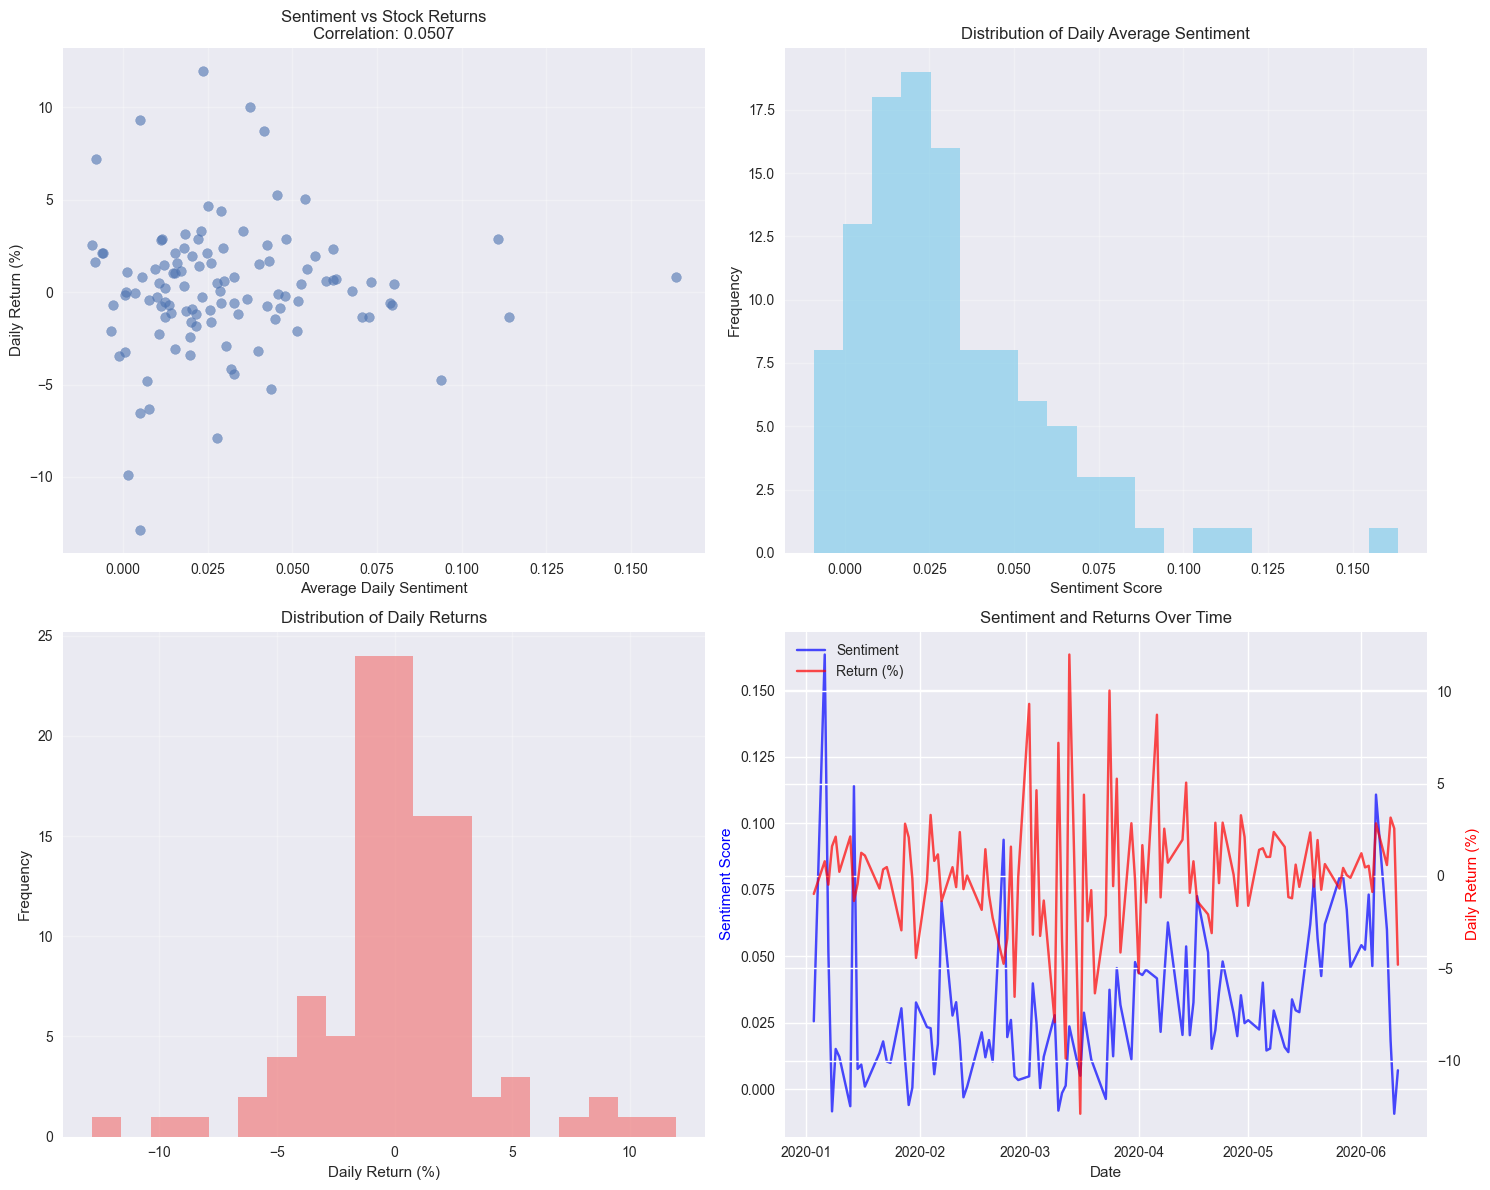

In [13]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Sentiment vs Returns Scatter
axes[0,0].scatter(merged_data['avg_sentiment'], merged_data['daily_return'], alpha=0.6)
axes[0,0].set_xlabel('Average Daily Sentiment')
axes[0,0].set_ylabel('Daily Return (%)')
axes[0,0].set_title(f'Sentiment vs Stock Returns\nCorrelation: {correlation:.4f}')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Sentiment Distribution
axes[0,1].hist(merged_data['avg_sentiment'].dropna(), bins=20, alpha=0.7, color='skyblue')
axes[0,1].set_xlabel('Sentiment Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Daily Average Sentiment')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Returns Distribution
axes[1,0].hist(merged_data['daily_return'].dropna(), bins=20, alpha=0.7, color='lightcoral')
axes[1,0].set_xlabel('Daily Return (%)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Daily Returns')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Time Series of Sentiment and Returns
ax2 = axes[1,1].twinx()
line1 = axes[1,1].plot(merged_data['date'], merged_data['avg_sentiment'], 
                      label='Sentiment', color='blue', alpha=0.7)
line2 = ax2.plot(merged_data['date'], merged_data['daily_return'], 
                label='Return (%)', color='red', alpha=0.7)
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Sentiment Score', color='blue')
ax2.set_ylabel('Daily Return (%)', color='red')
axes[1,1].set_title('Sentiment and Returns Over Time')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
axes[1,1].legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.savefig('sentiment_returns_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

Lag Correlation Analysis:
   lag_days  correlation
0         0     0.050704
1         1    -0.003551
2         2     0.186339
3         3    -0.017027
4         4     0.081774
5         5     0.177052


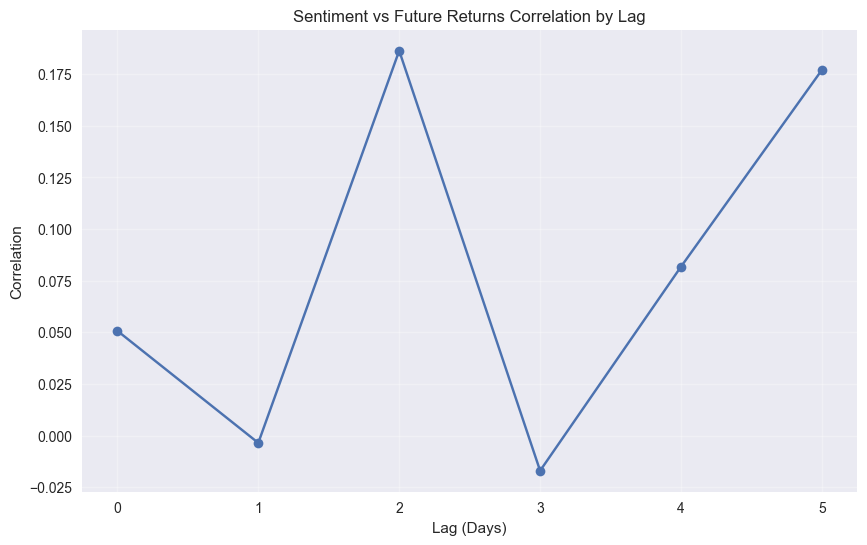

In [14]:
# Lag analysis - check if sentiment predicts future returns
def lag_correlation_analysis(df, max_lag=5):
    """Analyze correlation between sentiment and future returns"""
    results = []
    for lag in range(0, max_lag + 1):
        if lag == 0:
            corr = df['avg_sentiment'].corr(df['daily_return'])
        else:
            # Shift sentiment to predict future returns
            corr = df['avg_sentiment'].shift(lag).corr(df['daily_return'])
        
        results.append({'lag_days': lag, 'correlation': corr})
    
    return pd.DataFrame(results)

lag_results = lag_correlation_analysis(merged_data)
print("Lag Correlation Analysis:")
print(lag_results)

# Plot lag correlations
plt.figure(figsize=(10, 6))
plt.plot(lag_results['lag_days'], lag_results['correlation'], marker='o')
plt.xlabel('Lag (Days)')
plt.ylabel('Correlation')
plt.title('Sentiment vs Future Returns Correlation by Lag')
plt.grid(True, alpha=0.3)
plt.savefig('lag_correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Generate summary statistics
print("="*50)
print("TASK 3: CORRELATION ANALYSIS SUMMARY")
print("="*50)

print(f"\nDATASET OVERVIEW:")
print(f"• News articles analyzed: {len(news_df)}")
print(f"• Trading days analyzed: {len(merged_data)}")
print(f"• Stock ticker: {stock_ticker}")

print(f"\nSENTIMENT ANALYSIS:")
print(f"• Positive headlines: {len(news_df[news_df['sentiment_category'] == 'Positive'])}")
print(f"• Negative headlines: {len(news_df[news_df['sentiment_category'] == 'Negative'])}")
print(f"• Neutral headlines: {len(news_df[news_df['sentiment_category'] == 'Neutral'])}")
print(f"• Average sentiment score: {news_df['sentiment'].mean():.4f}")

print(f"\nSTOCK PERFORMANCE:")
print(f"• Average daily return: {merged_data['daily_return'].mean():.4f}%")
print(f"• Return volatility (std): {merged_data['daily_return'].std():.4f}%")

print(f"\nCORRELATION RESULTS:")
print(f"• Pearson correlation: {correlation:.4f}")
print(f"• Spearman correlation: {spearman_corr:.4f}")
print(f"• Kendall tau: {kendall_corr:.4f}")

# Interpretation
if abs(correlation) > 0.3:
    strength = "strong"
elif abs(correlation) > 0.1:
    strength = "moderate"
else:
    strength = "weak"

direction = "positive" if correlation > 0 else "negative"

print(f"\nINTERPRETATION:")
print(f"• There is a {strength} {direction} correlation between news sentiment and stock returns.")
print(f"• This suggests that {direction} news sentiment tends to be associated with {direction} stock returns.")

if abs(correlation) < 0.2:
    print(f"• Note: The weak correlation suggests other factors may be more important in driving stock returns.")

TASK 3: CORRELATION ANALYSIS SUMMARY

DATASET OVERVIEW:
• News articles analyzed: 28392
• Trading days analyzed: 111
• Stock ticker: AAPL

SENTIMENT ANALYSIS:
• Positive headlines: 4815
• Negative headlines: 1185
• Neutral headlines: 22392
• Average sentiment score: 0.0343

STOCK PERFORMANCE:
• Average daily return: 0.1659%
• Return volatility (std): 3.4886%

CORRELATION RESULTS:
• Pearson correlation: 0.0507
• Spearman correlation: 0.0523
• Kendall tau: 0.0388

INTERPRETATION:
• There is a weak positive correlation between news sentiment and stock returns.
• This suggests that positive news sentiment tends to be associated with positive stock returns.
• Note: The weak correlation suggests other factors may be more important in driving stock returns.
